In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import seaborn as sns
import random
import csv

from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler



In [2]:
import numpy as np
import pandas as pd
import pmdarima as pm
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection
from tensorflow.keras.layers import LSTM

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from matplotlib import pyplot as plt

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, PReLU
from keras_tuner.tuners import RandomSearch

from sklearn.metrics import mean_absolute_percentage_error

Using TensorFlow backend


In [4]:
df=pd.read_csv('icecream_sales_date 2009-2022.csv', index_col='date', parse_dates=True,encoding="utf-8")
df.head()

,sales,tokyo_temperature,holiday,Unnamed: 4,temperature_difference_2009_2018,temperature_difference_2019_2021,Unnamed: 7,2009,2010,2011,...,2015,2016,2017,2018,2019,2020,2021,2022,AVERAGE2009-2018,AVERAGE2019-2021
date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,17.59,10.6,1,NaN,0.521429,0.033333,1.0,10.2,11.0,9.1,...,10.4,10.6,10.8,9.4,10.3,11.1,10.3,9.4,10.078571,10.566667
2009-01-02,23.83,11.6,1,NaN,1.521429,1.033333,2.0,11.5,9.9,11.2,...,10.4,12.2,12.1,10.1,11.6,13.3,14.0,10.5,11.142857,12.966667
2009-01-03,22.94,10.7,1,NaN,0.621429,0.133333,3.0,13.7,13.2,12.3,...,15.5,14.9,13.4,16.9,15.4,16.0,17.9,16.6,14.942857,16.433333
2009-01-04,17.14,11.1,1,NaN,1.021429,0.533333,4.0,20.2,16.6,18.9,...,19.3,20.3,19.9,22.1,19.0,18.2,20.6,20.2,19.471429,19.266667
2009-01-05,10.32,11.8,0,NaN,1.721429,1.233333,5.0,23.6,23.0,22.2,...,26.4,25.2,25.1,24.6,25.3,24.0,24.1,23.5,24.242857,24.466667


In [5]:
#df_train=df["2009-01-01":"2018-12-31"]
#df_test=df["2019-01-01":"2019-12-31"]
df_19=df["2009-01-01":"2019-12-31"]

In [6]:
sales=df_19["sales"]
sales

date
2009-01-01    17.59
2009-01-02    23.83
2009-01-03    22.94
2009-01-04    17.14
2009-01-05    10.32
              ...  
2019-12-27    18.54
2019-12-28    24.99
2019-12-29    33.16
2019-12-30    25.73
2019-12-31    33.84
Name: sales, Length: 4015, dtype: float64

In [7]:
sales_train=sales["2009-01-01":"2018-12-31"]
sales_test=sales["2019-01-01":"2019-12-31"]

In [8]:
sales_np = np.array(sales, dtype=float)
sales_np

array([17.59, 23.83, 22.94, ..., 33.16, 25.73, 33.84])

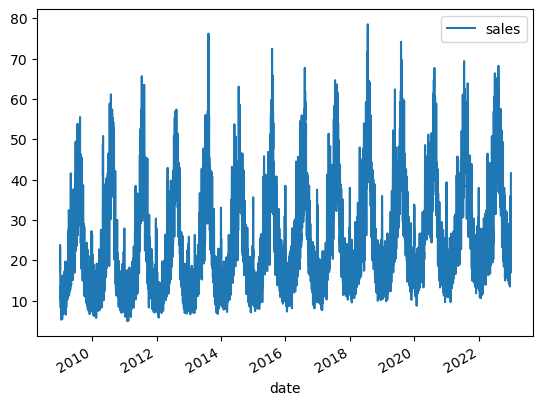

In [9]:
saless=df["sales"]
saless.plot()
#ヨコ軸のラベル
plt.legend()                                       #凡例表示
plt.show()

In [10]:
series=sales_np
series.shape

(4015,)

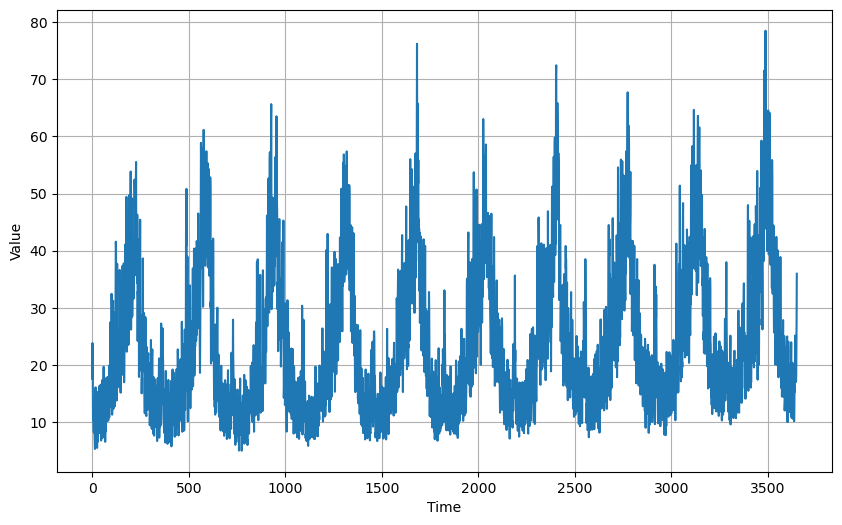

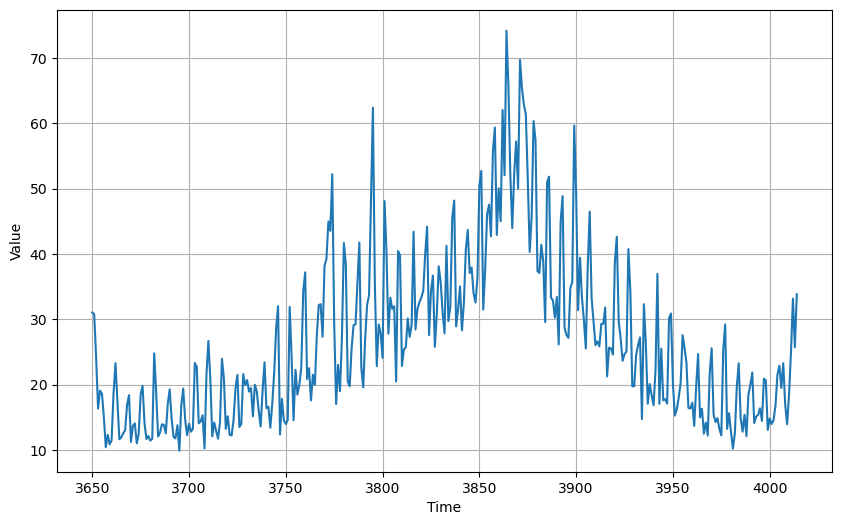

In [11]:
year=10
split_time = 365*year
time = np.arange(365*year+365, dtype="float32")

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


window_size = 10#小さいほうがうまくいきやすい気がする
batch_size = 128
shuffle_buffer_size = 4000

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train) # 学習セット
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid) # 検証セット
plt.show()

In [12]:
def windowing(df, window_size):
  x = []
  y = []

  for i in range(len(df) - window_size):
    x_result = df[i:i+window_size].to_list()
    x.append(x_result)
    y_result = df[i+window_size]
    y.append(y_result)

  return np.array(x), np.array(y)

In [13]:
window_size = 20

x_train_lstm, y_train_lstm = windowing(sales_train, window_size)
x_test_lstm, y_test_lstm = windowing(sales_test,window_size)

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [15]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D

# build lstm model
lstm_model = Sequential()
lstm_model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None, 1]))
lstm_model.add(Dense(1))
#lstm_model.add(LSTM(100, input_shape=[window_size, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.5))
#lstm_model.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.5, activation='relu')) 
#lstm_model.add(Dense(1))
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         512       
                                                                 
 dense (Dense)               (None, None, 1)           129       
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [16]:
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, 
        verbose=1, mode='auto', restore_best_weights=True)

In [17]:
cp = ModelCheckpoint('model/', save_best_only=True)
lstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())

In [18]:
# train lstm model
history = lstm_model.fit(x_train_lstm, y_train_lstm, validation_data=(x_test_lstm, y_test_lstm), epochs=50, batch_size=32, callbacks=[cp])

Epoch 1/50
101/114 [=========================>....] - ETA: 0s - loss: 574.0797 - root_mean_squared_error: 23.9600

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 2s 12ms/step - loss: 560.4410 - root_mean_squared_error: 23.6761 - val_loss: 518.0531 - val_root_mean_squared_error: 22.8536
Epoch 2/50
101/114 [=========================>....] - ETA: 0s - loss: 374.0917 - root_mean_squared_error: 19.3414

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 7ms/step - loss: 368.1714 - root_mean_squared_error: 19.1940 - val_loss: 251.7937 - val_root_mean_squared_error: 15.9251
Epoch 3/50
 87/114 [=====================>........] - ETA: 0s - loss: 289.4336 - root_mean_squared_error: 17.0127

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 7ms/step - loss: 286.7626 - root_mean_squared_error: 16.9334 - val_loss: 159.1476 - val_root_mean_squared_error: 12.6580
Epoch 4/50
111/114 [============================>.] - ETA: 0s - loss: 273.8507 - root_mean_squared_error: 16.5484

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 7ms/step - loss: 273.2656 - root_mean_squared_error: 16.5325 - val_loss: 139.5246 - val_root_mean_squared_error: 11.8521
Epoch 5/50
 89/114 [======================>.......] - ETA: 0s - loss: 271.7193 - root_mean_squared_error: 16.4839

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 7ms/step - loss: 271.2225 - root_mean_squared_error: 16.4647 - val_loss: 136.7897 - val_root_mean_squared_error: 11.7353
Epoch 6/50
110/114 [===========================>..] - ETA: 0s - loss: 269.1617 - root_mean_squared_error: 16.4062

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 8ms/step - loss: 269.4855 - root_mean_squared_error: 16.4108 - val_loss: 134.5294 - val_root_mean_squared_error: 11.6380
Epoch 7/50
100/114 [=========================>....] - ETA: 0s - loss: 265.7109 - root_mean_squared_error: 16.3006

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 9ms/step - loss: 266.7225 - root_mean_squared_error: 16.3319 - val_loss: 131.5146 - val_root_mean_squared_error: 11.5070
Epoch 8/50
100/114 [=========================>....] - ETA: 0s - loss: 263.7236 - root_mean_squared_error: 16.2396

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 10ms/step - loss: 265.0846 - root_mean_squared_error: 16.2839 - val_loss: 130.7263 - val_root_mean_squared_error: 11.4725
Epoch 9/50
100/114 [=========================>....] - ETA: 0s - loss: 264.7698 - root_mean_squared_error: 16.2718

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 8ms/step - loss: 263.2020 - root_mean_squared_error: 16.2296 - val_loss: 128.9018 - val_root_mean_squared_error: 11.3923
Epoch 10/50
 99/114 [=========================>....] - ETA: 0s - loss: 261.0264 - root_mean_squared_error: 16.1563

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 8ms/step - loss: 260.4801 - root_mean_squared_error: 16.1431 - val_loss: 128.7460 - val_root_mean_squared_error: 11.3856
Epoch 11/50
 94/114 [=======================>......] - ETA: 0s - loss: 259.9665 - root_mean_squared_error: 16.1235

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 8ms/step - loss: 258.0842 - root_mean_squared_error: 16.0618 - val_loss: 126.3709 - val_root_mean_squared_error: 11.2803
Epoch 12/50
102/114 [=========================>....] - ETA: 0s - loss: 258.1594 - root_mean_squared_error: 16.0673

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 9ms/step - loss: 255.7755 - root_mean_squared_error: 15.9987 - val_loss: 125.1518 - val_root_mean_squared_error: 11.2261
Epoch 13/50
101/114 [=========================>....] - ETA: 0s - loss: 254.7119 - root_mean_squared_error: 15.9597

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 8ms/step - loss: 255.5815 - root_mean_squared_error: 15.9734 - val_loss: 125.1283 - val_root_mean_squared_error: 11.2253
Epoch 14/50
105/114 [==========================>...] - ETA: 0s - loss: 257.1662 - root_mean_squared_error: 16.0364

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 8ms/step - loss: 255.1716 - root_mean_squared_error: 15.9720 - val_loss: 123.7991 - val_root_mean_squared_error: 11.1659
Epoch 15/50
105/114 [==========================>...] - ETA: 0s - loss: 251.3103 - root_mean_squared_error: 15.8528

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 7ms/step - loss: 251.8459 - root_mean_squared_error: 15.8731 - val_loss: 121.9548 - val_root_mean_squared_error: 11.0828
Epoch 16/50
 88/114 [======================>.......] - ETA: 0s - loss: 243.3920 - root_mean_squared_error: 15.6010

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 8ms/step - loss: 249.7975 - root_mean_squared_error: 15.8031 - val_loss: 120.4531 - val_root_mean_squared_error: 11.0148
Epoch 17/50
114/114 [==============================] - 0s 2ms/step - loss: 248.0784 - root_mean_squared_error: 15.7568 - val_loss: 124.3597 - val_root_mean_squared_error: 11.1925
Epoch 18/50
 96/114 [========================>.....] - ETA: 0s - loss: 244.1737 - root_mean_squared_error: 15.6261

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 9ms/step - loss: 245.8099 - root_mean_squared_error: 15.6841 - val_loss: 120.3379 - val_root_mean_squared_error: 11.0105
Epoch 19/50
105/114 [==========================>...] - ETA: 0s - loss: 244.9901 - root_mean_squared_error: 15.6522

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 8ms/step - loss: 244.9451 - root_mean_squared_error: 15.6470 - val_loss: 118.9399 - val_root_mean_squared_error: 10.9468
Epoch 20/50
 93/114 [=======================>......] - ETA: 0s - loss: 242.2530 - root_mean_squared_error: 15.5645

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 8ms/step - loss: 243.5626 - root_mean_squared_error: 15.6072 - val_loss: 117.6940 - val_root_mean_squared_error: 10.8899
Epoch 21/50
114/114 [==============================] - 0s 2ms/step - loss: 242.6553 - root_mean_squared_error: 15.5616 - val_loss: 118.7580 - val_root_mean_squared_error: 10.9396
Epoch 22/50
114/114 [==============================] - 0s 2ms/step - loss: 239.8124 - root_mean_squared_error: 15.4956 - val_loss: 118.2689 - val_root_mean_squared_error: 10.9176
Epoch 23/50
114/114 [==============================] - 0s 2ms/step - loss: 238.6308 - root_mean_squared_error: 15.4432 - val_loss: 117.7261 - val_root_mean_squared_error: 10.8931
Epoch 24/50
114/114 [==============================] - 0s 2ms/step - loss: 237.1340 - root_mean_squared_error: 15.4054 - val_loss: 117.8066 - val_root_mean_squared_error: 10.8975
Epoch 25/50
 86/114 [=====================>........] - ETA: 0s - loss: 228.7874 - root_mean_squared_error: 15.1257

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 7ms/step - loss: 235.6638 - root_mean_squared_error: 15.3383 - val_loss: 116.1082 - val_root_mean_squared_error: 10.8193
Epoch 26/50
 92/114 [=======================>......] - ETA: 0s - loss: 238.6856 - root_mean_squared_error: 15.4495

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 9ms/step - loss: 233.7454 - root_mean_squared_error: 15.2968 - val_loss: 115.7029 - val_root_mean_squared_error: 10.8011
Epoch 27/50
 95/114 [========================>.....] - ETA: 0s - loss: 234.8864 - root_mean_squared_error: 15.3260

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 8ms/step - loss: 231.0737 - root_mean_squared_error: 15.2063 - val_loss: 115.3128 - val_root_mean_squared_error: 10.7835
Epoch 28/50
114/114 [==============================] - 0s 2ms/step - loss: 229.3471 - root_mean_squared_error: 15.1410 - val_loss: 116.2520 - val_root_mean_squared_error: 10.8280
Epoch 29/50
 99/114 [=========================>....] - ETA: 0s - loss: 226.6147 - root_mean_squared_error: 15.0537

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 8ms/step - loss: 228.2603 - root_mean_squared_error: 15.1042 - val_loss: 114.2373 - val_root_mean_squared_error: 10.7345
Epoch 30/50
 99/114 [=========================>....] - ETA: 0s - loss: 224.3320 - root_mean_squared_error: 14.9777

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 7ms/step - loss: 226.4079 - root_mean_squared_error: 15.0529 - val_loss: 113.5676 - val_root_mean_squared_error: 10.7037
Epoch 31/50
114/114 [==============================] - 0s 2ms/step - loss: 223.8157 - root_mean_squared_error: 14.9653 - val_loss: 117.0785 - val_root_mean_squared_error: 10.8687
Epoch 32/50
 95/114 [========================>.....] - ETA: 0s - loss: 223.3809 - root_mean_squared_error: 14.9459

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 9ms/step - loss: 223.2030 - root_mean_squared_error: 14.9456 - val_loss: 113.4640 - val_root_mean_squared_error: 10.7003
Epoch 33/50
114/114 [==============================] - 0s 2ms/step - loss: 220.4956 - root_mean_squared_error: 14.8460 - val_loss: 115.5016 - val_root_mean_squared_error: 10.7967
Epoch 34/50
114/114 [==============================] - 0s 2ms/step - loss: 218.4039 - root_mean_squared_error: 14.7813 - val_loss: 122.8955 - val_root_mean_squared_error: 11.1380
Epoch 35/50
109/114 [===========================>..] - ETA: 0s - loss: 214.7984 - root_mean_squared_error: 14.6560

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 8ms/step - loss: 215.1345 - root_mean_squared_error: 14.6743 - val_loss: 112.4151 - val_root_mean_squared_error: 10.6529
Epoch 36/50
114/114 [==============================] - 0s 2ms/step - loss: 214.3689 - root_mean_squared_error: 14.6534 - val_loss: 121.2795 - val_root_mean_squared_error: 11.0661
Epoch 37/50
114/114 [==============================] - 0s 3ms/step - loss: 211.7023 - root_mean_squared_error: 14.5474 - val_loss: 118.6342 - val_root_mean_squared_error: 10.9455
Epoch 38/50
114/114 [==============================] - 0s 2ms/step - loss: 209.6291 - root_mean_squared_error: 14.4859 - val_loss: 116.5301 - val_root_mean_squared_error: 10.8487
Epoch 39/50
108/114 [===========================>..] - ETA: 0s - loss: 210.1858 - root_mean_squared_error: 14.4978

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 8ms/step - loss: 208.8719 - root_mean_squared_error: 14.4582 - val_loss: 112.3329 - val_root_mean_squared_error: 10.6521
Epoch 40/50
114/114 [==============================] - 0s 2ms/step - loss: 206.2130 - root_mean_squared_error: 14.3542 - val_loss: 119.6987 - val_root_mean_squared_error: 10.9971
Epoch 41/50
114/114 [==============================] - 0s 2ms/step - loss: 204.1658 - root_mean_squared_error: 14.2946 - val_loss: 118.1042 - val_root_mean_squared_error: 10.9243
Epoch 42/50
108/114 [===========================>..] - ETA: 0s - loss: 201.6657 - root_mean_squared_error: 14.2009

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 1s 7ms/step - loss: 202.3359 - root_mean_squared_error: 14.2348 - val_loss: 109.2381 - val_root_mean_squared_error: 10.5063
Epoch 43/50
114/114 [==============================] - 0s 2ms/step - loss: 200.0296 - root_mean_squared_error: 14.1446 - val_loss: 114.5482 - val_root_mean_squared_error: 10.7598
Epoch 44/50
114/114 [==============================] - 0s 2ms/step - loss: 198.6083 - root_mean_squared_error: 14.0949 - val_loss: 120.4560 - val_root_mean_squared_error: 11.0350
Epoch 45/50
114/114 [==============================] - 0s 3ms/step - loss: 196.2586 - root_mean_squared_error: 14.0156 - val_loss: 123.2980 - val_root_mean_squared_error: 11.1653
Epoch 46/50
114/114 [==============================] - 0s 2ms/step - loss: 194.6108 - root_mean_squared_error: 13.9545 - val_loss: 113.2622 - val_root_mean_squared_error: 10.7009
Epoch 47/50
114/114 [==============================] - 0s 2ms/step - loss: 191.5901 - root_mean_squared_error: 13.846

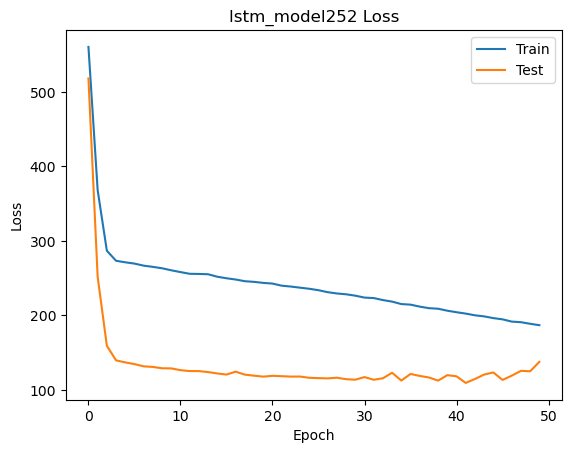

In [19]:
# plot train and test loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('lstm_model252 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [20]:
loss_df = pd.DataFrame({'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss = pd.DataFrame({'min': loss_df.min(), 'max': loss_df.max()})
loss
print(loss_df.min())

loss        186.784241
val_loss    109.238075
dtype: float64


In [21]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [22]:
forecast = model_forecast(lstm_model, series[split_time - window_size:-1], window_size)[:,0]

3/3 [==============================] - 2s 734ms/step


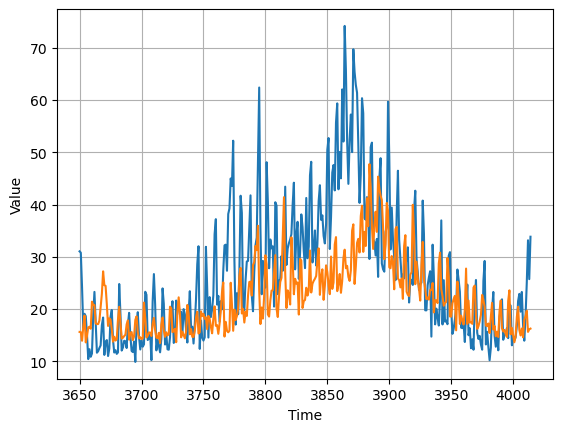

In [23]:
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [24]:
print('RMSE : ',np.sqrt(((x_valid - forecast)**2).mean()))
mae=mean_absolute_error(x_valid, forecast)
print('MAE : ',mae)

RMSE :  15.164658510153915
MAE :  7.712617464980034
